# Earthly Insights: Uncovering the Planet's Patterns
### Analyzing raster data for the Earth's climate
Kamal Narra <br/>
Jayson Hurst <br/>
Nathan Tablang <br/>

### Table of contents:
1. Introduction
2. Data & Plan
3. Part 1: Cleaning raster datasets
4. Part 2: Visualizing the data  
&nbsp;&nbsp;&nbsp;I&nbsp; Precipitation<br/>
&nbsp;&nbsp;&nbsp;II&nbsp; Average Temperature<br/>
&nbsp;&nbsp;&nbsp;III&nbsp; Water Vapor<br/>
&nbsp;&nbsp;&nbsp;IV&nbsp; Wind Speed<br/>
&nbsp;&nbsp;&nbsp;V&nbsp; Visualizing each feature on a map<br/>
&nbsp;&nbsp;&nbsp;VI&nbsp; All Together<br/>
5. Part 3: Regression Analysis  
&nbsp;&nbsp;&nbsp;I&nbsp; Colinearity<br/>
&nbsp;&nbsp;&nbsp;II&nbsp; Evaluation<br/>


## Introduction <a class="anchor" id="introduction"></a>

Everything leads back to the roots: what we eat, what we touch, what we breathe, and anything in between could be traced back to human marvels of agricultural engineering.
From centuries of nomadic lifestyle to the modern predispostition of globalization and industrialization, caring more about farms, crops, soils, and others have never been more important than ever in the face of rapid climate change. Amongst many things, finding prime locations of crops could make great chain reactions as its productions could be used for the next goods to the other, up until the necessities that we interact with on a daily basis.

By providing data analytics, we hope to pinpoint such locations and provided a better understanding of patterns and trends that could then be used for optimizing productivity, with the goal in mind of providing enlightenment for the consumers, farmers, and middlemen.


## Data & Plan <a class="anchor" id="data"></a>
[Raster data](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/what-is-raster-data.htm) is a type of spacial data that is represented as a grid of cells, with each cell containing a value that corresponds to a certain feature of the area, such as wind speed, precipitation, temperature, etc. It is an ideal format for analyzing large areas, such as the whole planet, as it allows us to quickly identify patterns and trends across a wide range of locations. This project seeks to analyze these kinds of data collected from a variety of sources to gain insights into the Earth's climate.

We gathered datasets from many government and private websites for four features: <br/>
- wind speed<br/>
- precipitation<br/>
- temperature<br/>
- vapor concentration<br/>

We then parsed these datasets into a raster format for each feature: by combining all the raster datasets of the four features into a single area, we can use them to predict values for specific tasks, such as finding the most suitable locations to grow a certain type of crop.

The project is composed of three main sections:<br/>
- First, we visualize the process of cleaning raster data.<br/>
- Second, we use two regression models, [linear](https://www.ibm.com/topics/linear-regression#:~:text=Resources-,What%20is%20linear%20regression%3F,is%20called%20the%20independent%20variable.) and [random forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2), to predict a specific feature and compare the [RMSE](https://c3.ai/glossary/data-science/root-mean-square-error-rmse/#:~:text=Root%20mean%20square%20error%20or,true%20values%20using%20Euclidean%20distance.) values of each regression model to examine their utility for predicting our set of features. <br/>
- Finally, we analyze our results and draw conclusions about the effectiveness of both models.


In [ ]:
# SETUP
import rasterio as rio
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rioxarray as rxr
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyspatialml import Raster
from pyspatialml import Raster
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from pyspatialml.preprocessing import xy_coordinates
from tempfile import NamedTemporaryFile
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math


## Part 1: Cleaning raster datasets <a class="anchor" id="part-1"></a>

To start we need to co-register each raster dataset with the same template to ensure that their individual cells are aligned. Co-registering is the process of transforming a raster dataset from one coordinate system to another, allowing us to compare different datasets in the same coordinate system. We use the [resampling method of nearest](https://desktop.arcgis.com/en/arcmap/10.3/tools/environments/resampling-method.htm#:~:text=The%20resampling%20technique%20used%3A,four%20nearest%20input%20cell%20centers.) to ensure that the values in each cell are not changed as a result of the transformation. The function below function will take in three parameters: a **template raster**, the **input raster path**, and the **output raster path**. 

The **template raster** will provide the **coordinate system, width, height, and bounds**. We then use this information to calculate the transform and output raster dimensions for the input raster. The output raster will have the same metadata as the input, with the exception of the coordinate system, transform, width, height, and nodata value, which will be set to the values determined by the template. The input raster will then be reprojected to the template's coordinate system for each of its bands and resampled using the nearest method. Finally, the result will be written to the output raster.

In [ ]:
def coregister(template, in_path, out_path):
    with rio.open(in_path) as input:
        with rio.open(template) as template:
            out_crs = template.crs
            out_transform, out_width, out_height = calculate_default_transform(
                input.crs,
                out_crs,
                template.width,
                template.height,
                *template.bounds,
            )
        out_kwargs = input.meta.copy()
        out_kwargs.update({
            "crs": out_crs,
            "transform": out_transform,
            "width": out_width,
            "height": out_height,
            "nodata": 0
        })
        with rio.open(out_path, "w", **out_kwargs) as output:
            for i in range(1, input.count + 1): reproject(
                    source = rio.band(input, i),
                    destination = rio.band(output, i),
                    src_transform = input.transform,
                    src_crs = input.crs,
                    dst_transform = out_transform,
                    dst_crs = out_crs,
                    resampling = Resampling.nearest
                )

In [ ]:
template = "s3://320final/template.tif"

In [ ]:
prec_in = "s3://320final/prec.tif"
temp_in = "s3://320final/temp.tif"
vapr_in = "s3://320final/vapor.tif"
wind_in = "s3://320final/wind.tif"

In [ ]:
prec_cln = "prec-cleaned"
temp_cln = "temp-cleaned"
vapr_cln = "vapr-cleaned"
wind_cln = "wind-cleaned"

In [ ]:
coregister(template, prec_in, prec_cln)
coregister(template, temp_in, temp_cln)
coregister(template, vapr_in, vapr_cln)
coregister(template, wind_in, wind_cln)

## Part 2: Visualizing the data <a class="anchor" id="part-2"></a>

Now with the clean raster data, we can visualize the co-registering process by comparing our input data with the transformed output. To do this, four parameters are taken in as input - the input raster path, the output raster path, and the dataset and variable name. The two rasters are opened and squeezed to remove any single-dimensional axes. Then, a figure with seven subplots is created. Four of the subplots are used to display the input and output rasters, two are used to show the respective histograms, and one is used to show the difference in the histograms. 

The imshow function is used to create maps of the input and output rasters. The plot.hist function is used to create histograms for the two rasters, and then a histogram of the difference between them is created. The upper and lower bounds of the difference histogram are set based on the minimum and maximum values of the difference. Finally, the figure layout is set and a horizontal line is added to the difference histogram at 0.

In [ ]:
def visualize_difference(in_path, out_path, dataset_name, var_name):
    input =  rxr.open_rasterio(in_path, masked = True)
    output = rxr.open_rasterio(out_path, masked = True)

    sq_output = output.squeeze()
    sq_input = input.squeeze()

    fig = plt.figure(figsize=(32,32))
    fig.suptitle(dataset_name + ": Input Data vs Coregistered Data", fontsize = 50, color = "#00401D")

    ax1 = fig.add_subplot(421)
    ax2 = fig.add_subplot(422)
    ax3 = fig.add_subplot(423)
    ax4 = fig.add_subplot(424)
    ax5 = fig.add_subplot(425)
    ax6 = fig.add_subplot(426)
    ax7 = fig.add_subplot(414)
    
    map1 = ax1.imshow(sq_input)
    map2 = ax2.imshow(sq_output)
    input.plot.hist(ax=ax3, color="#191970")
    output.plot.hist(ax=ax4, color="#191970")
    hist1, bins, patches = input.plot.hist(ax=ax5, color="#009e96", density = True)
    hist2 , _, _ = output.plot.hist(ax=ax6, color="#009e96", density= True)
    ax7.hist(bins[:-1], bins, weights = np.subtract(hist1,hist2), color = "#00FF13")

    ax1.set_title("Map of Input Data", fontsize = 30)
    ax1.tick_params(axis='both', which='both', labelsize=10)
    cb = ep.colorbar(map1)
    cb.set_label(var_name, fontsize = 20)


    ax2.set_title("Map of Coregistered Data", fontsize = 30)
    ax2.tick_params(axis='both', which='both', labelsize=10)
    cb = ep.colorbar(map2)
    cb.set_label(var_name, fontsize = 20)



    ax3.set_title("Histogram of Input Data", fontsize = 30)
    ax3.set_xlabel(var_name, fontsize=20)
    ax3.set_ylabel("Count", fontsize=20)
    ax3.tick_params(axis='both', which='both', labelsize=10)


    ax4.set_title("Histogram of Coregistered Data", fontsize = 30)
    ax4.set_xlabel(var_name, fontsize=20)
    ax4.set_ylabel("Count", fontsize=20)
    ax4.tick_params(axis='both', which='both', labelsize=10)



    ax5.set_title("Density Histogram of Input Data", fontsize = 30)
    ax5.set_xlabel(var_name, fontsize=20)
    ax5.set_ylabel("Rel. Freq.", fontsize=20)
    ax5.tick_params(axis='both', which='both', labelsize=10)



    ax6.set_title("Density Histogram of Coregistered Data", fontsize = 30)
    ax6.set_xlabel(var_name, fontsize=20)
    ax6.set_ylabel("Rel. Freq.", fontsize=20)
    ax6.tick_params(axis='both', which='both', labelsize=10)


    ax7.set_title("Histogram of Difference in Relative Frequency Between Input and Coregistered Data", fontsize = 30)
    ax7.set_xlabel(var_name, fontsize=20)
    ax7.set_ylabel("Diff. in Rel. Freq.", fontsize=20)
    ax7.tick_params(axis='both', which='both', labelsize=10)
    upper = max(abs(np.subtract(hist1,hist2).min()), abs(np.subtract(hist1,hist2).max())) + 0.00005
    lower = -1 * upper
    ax7.axhline(y=0)

    fig.tight_layout(pad = 7.0)

### Precipitation <a class="anchor" id="precipitation"></a>

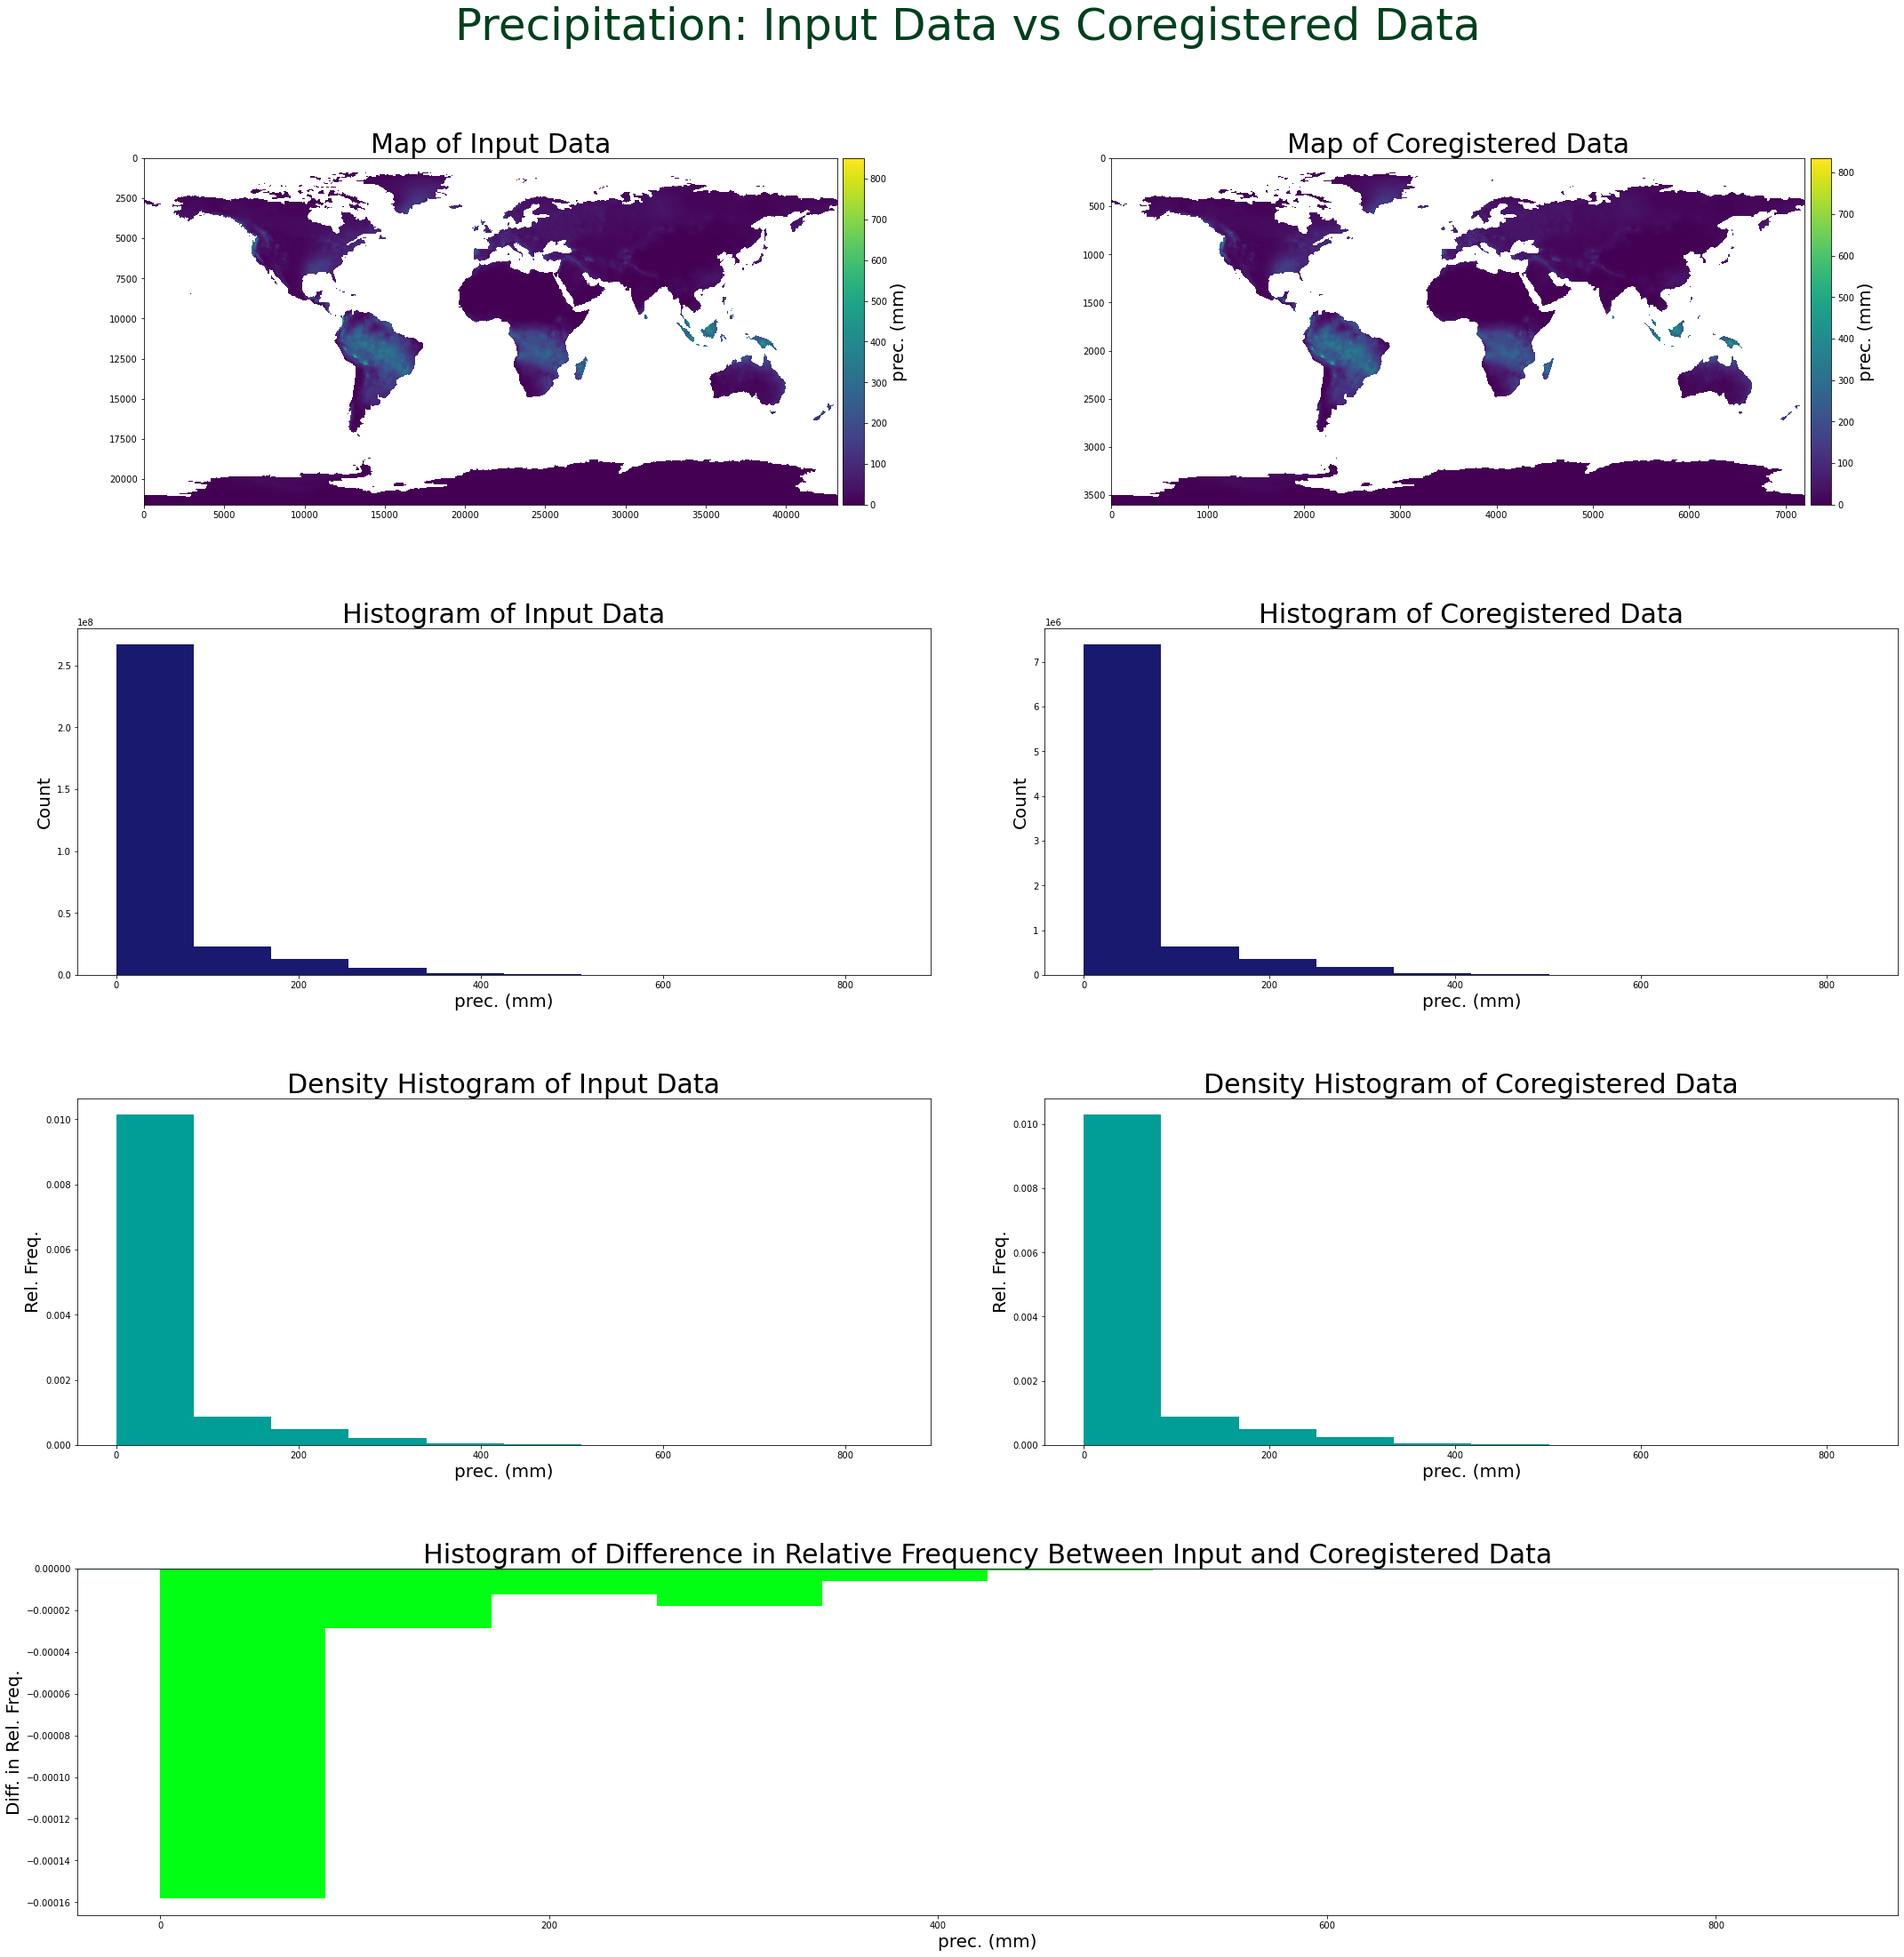

In [ ]:
visualize_difference(prec_in, prec_cln, "Precipitation", "prec. (mm)")

### Average Temperature <a class="anchor" id="avg"></a>

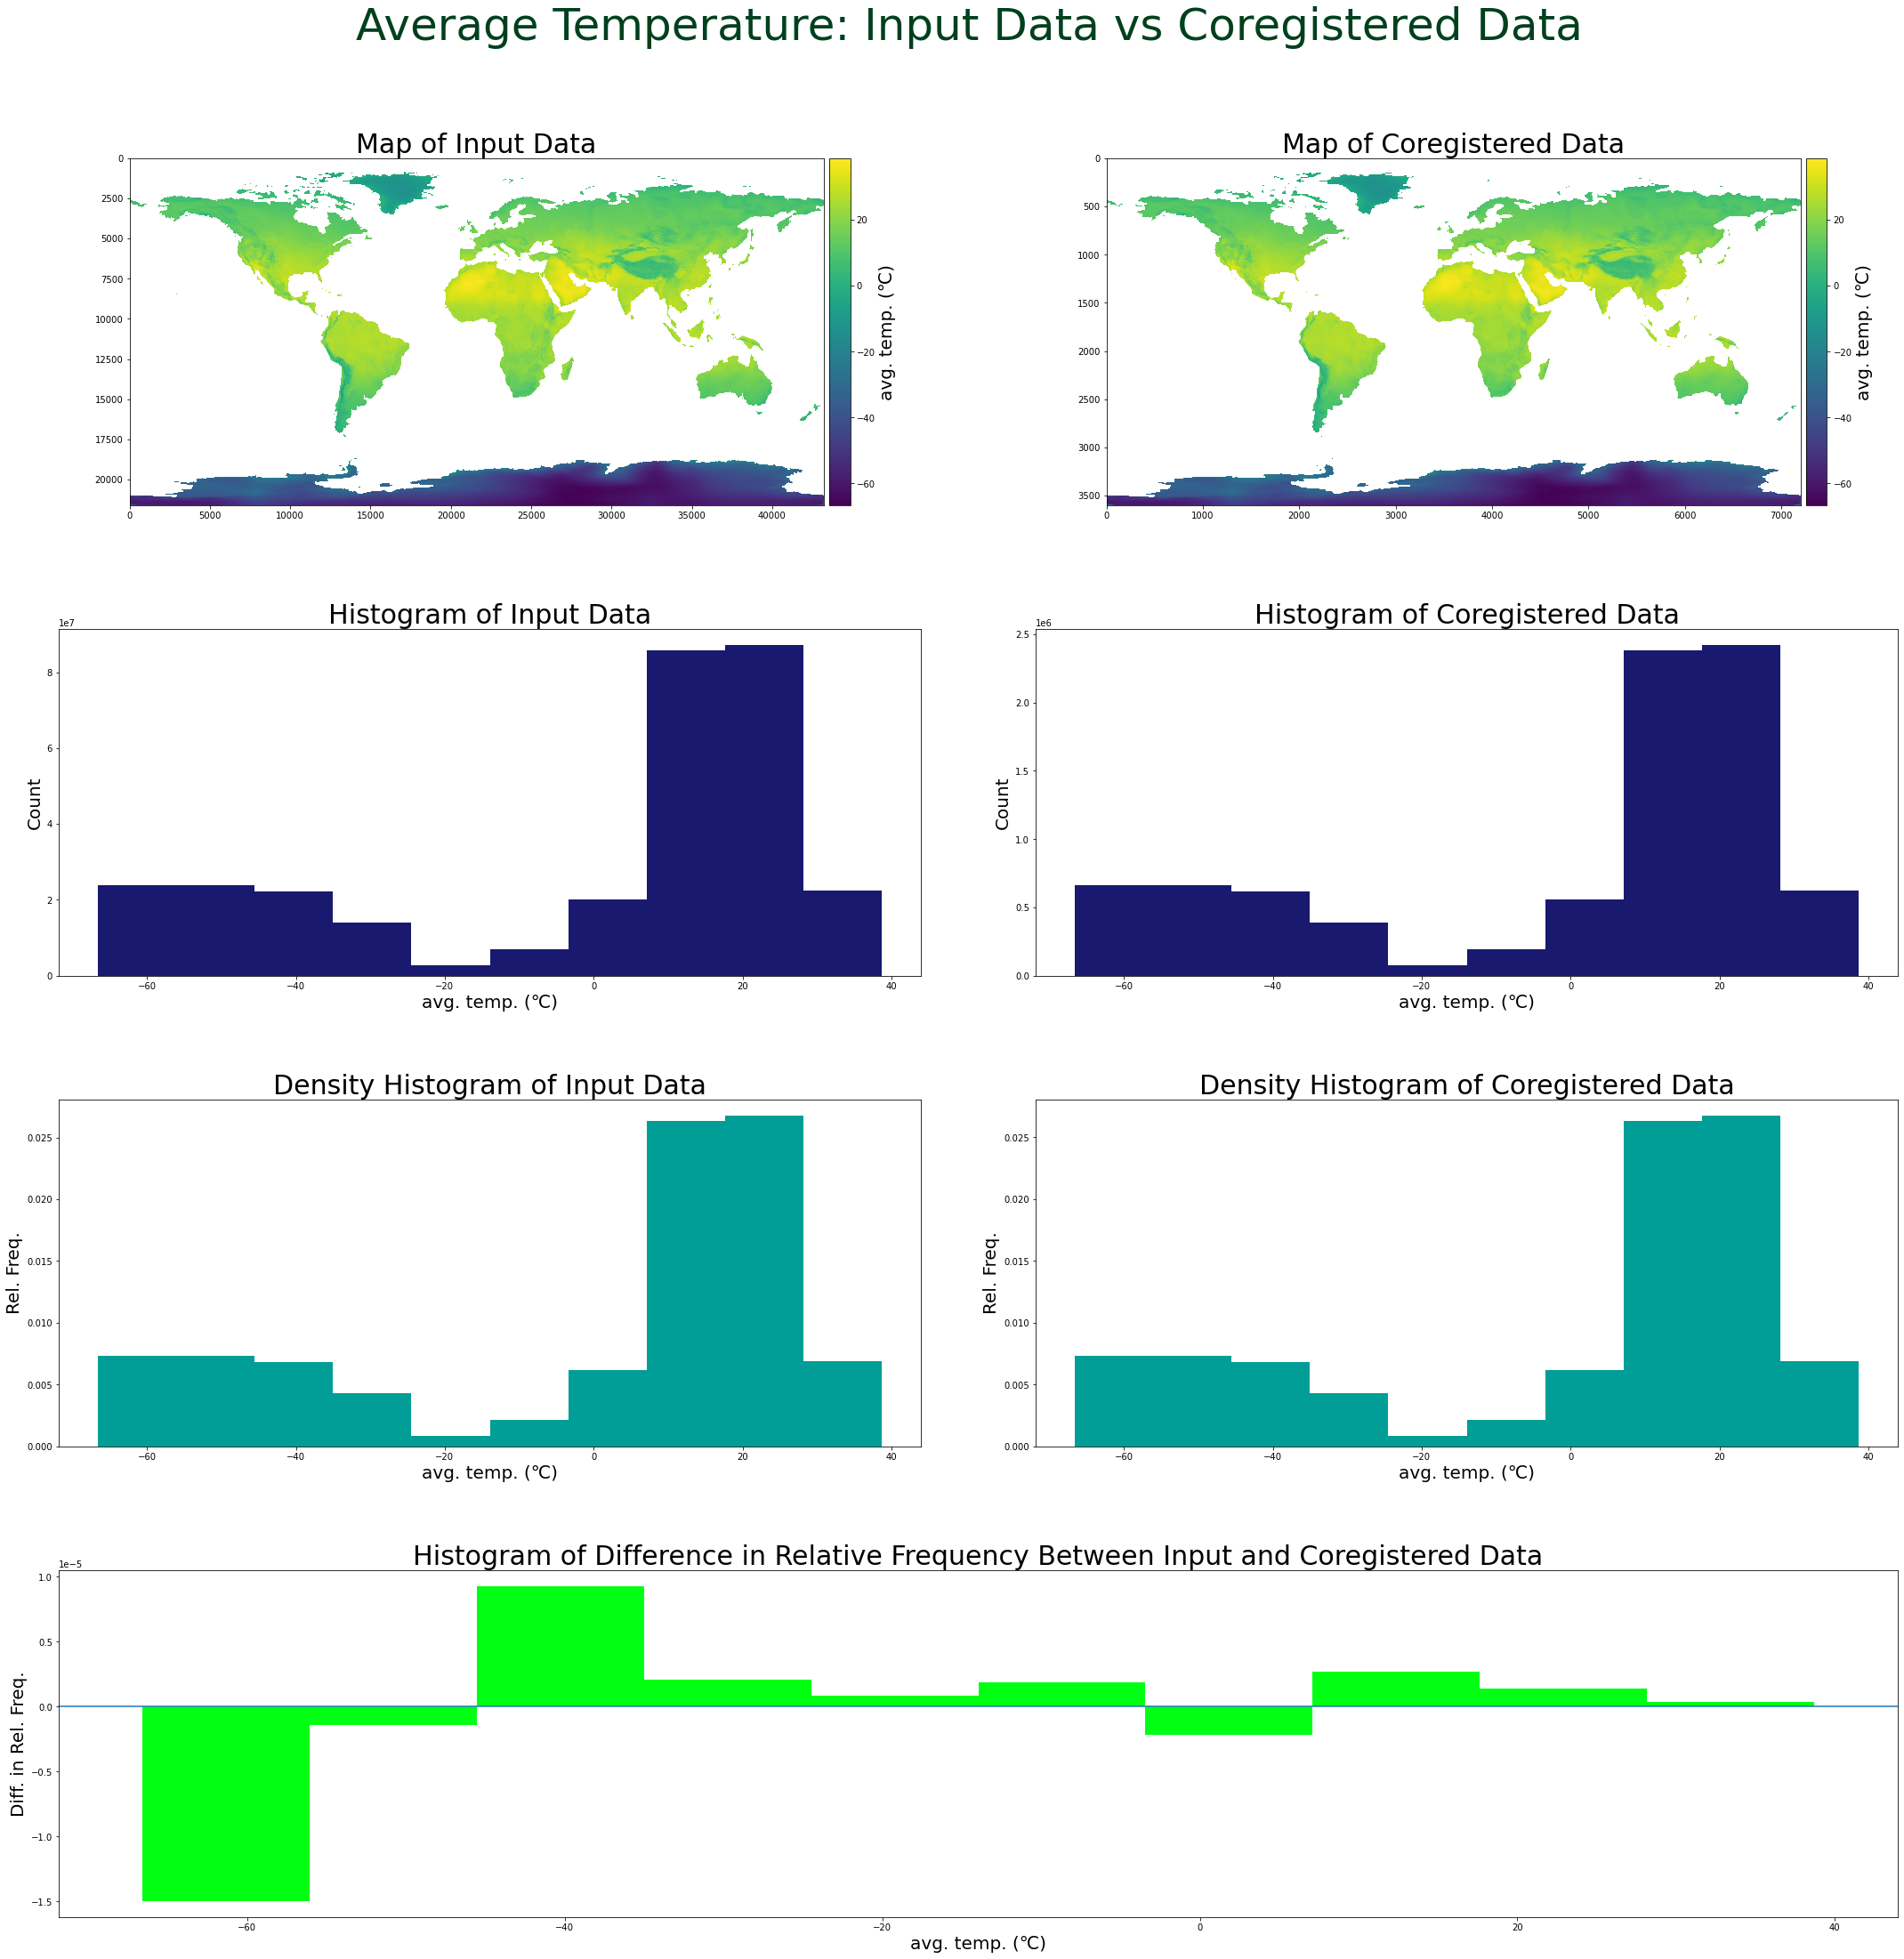

In [ ]:
visualize_difference(temp_in, temp_cln, "Average Temperature", "avg. temp. (" + u"\u2103" + ")")


### Water Vapor Pressure <a class="anchor" id="wv"></a>

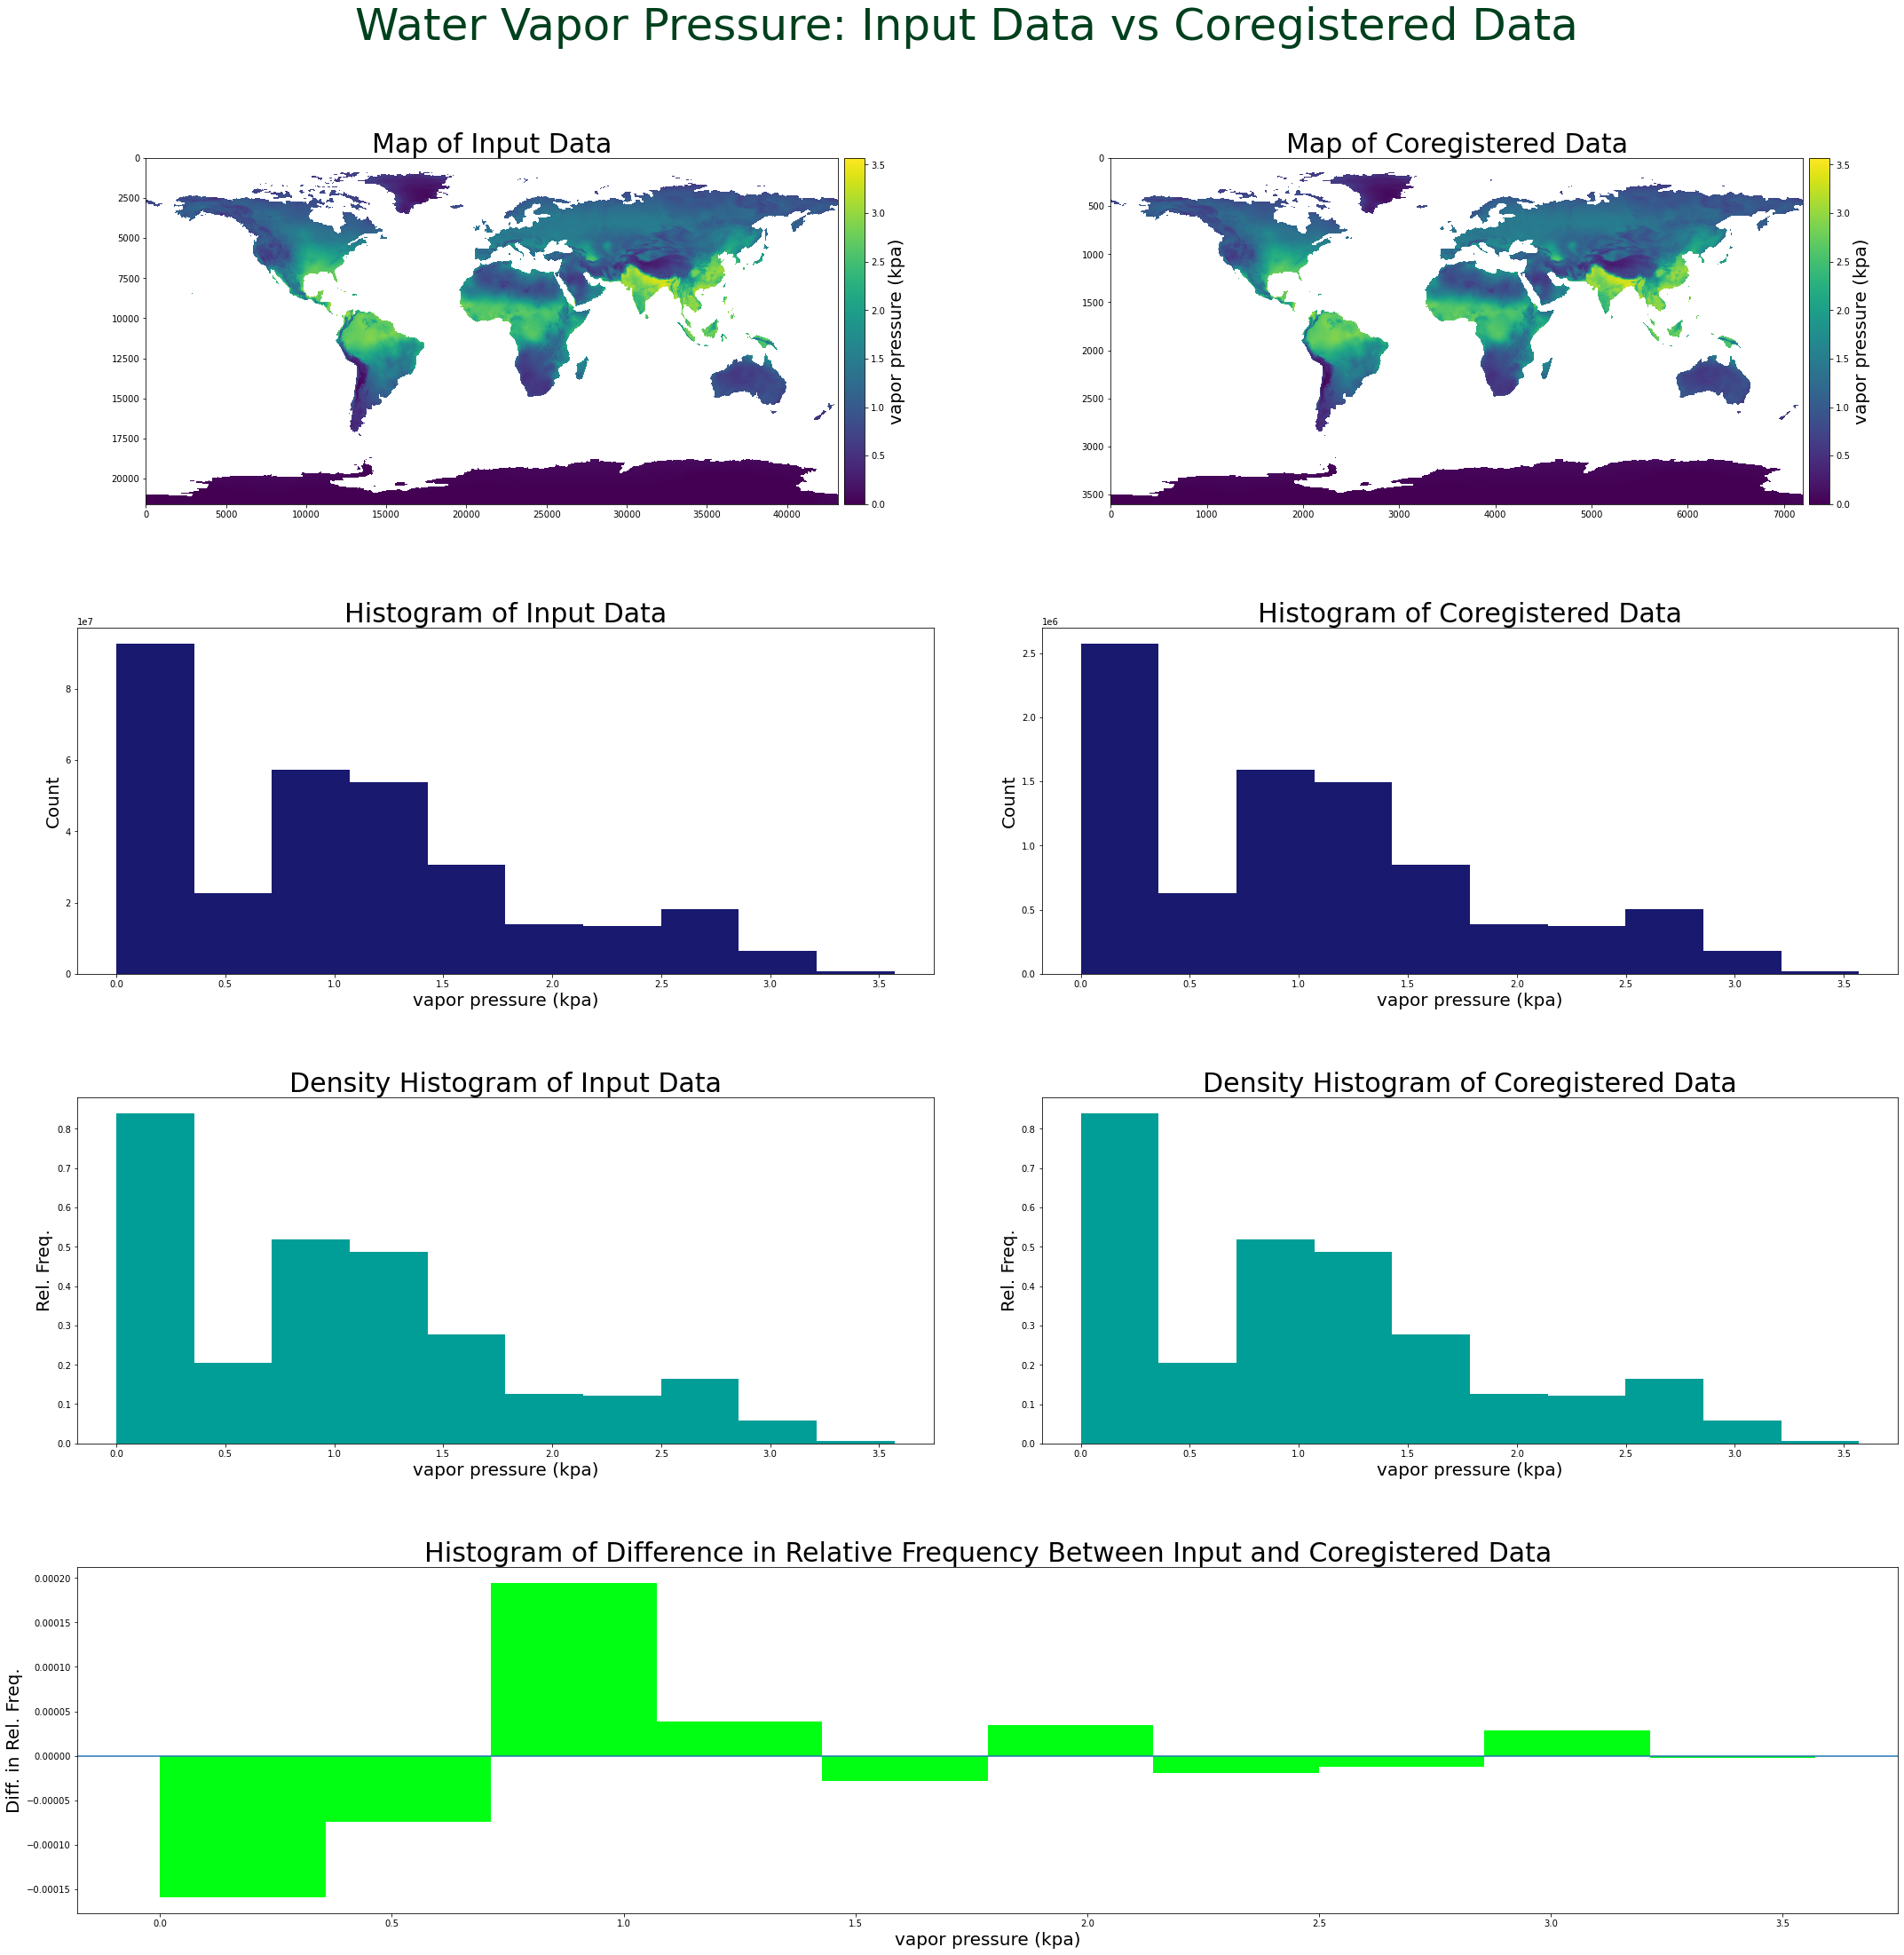

In [ ]:
visualize_difference(vapr_in, vapr_cln, "Water Vapor Pressure", "vapor pressure (kpa)")


### Wind Speed <a class="anchor" id="ws"></a>

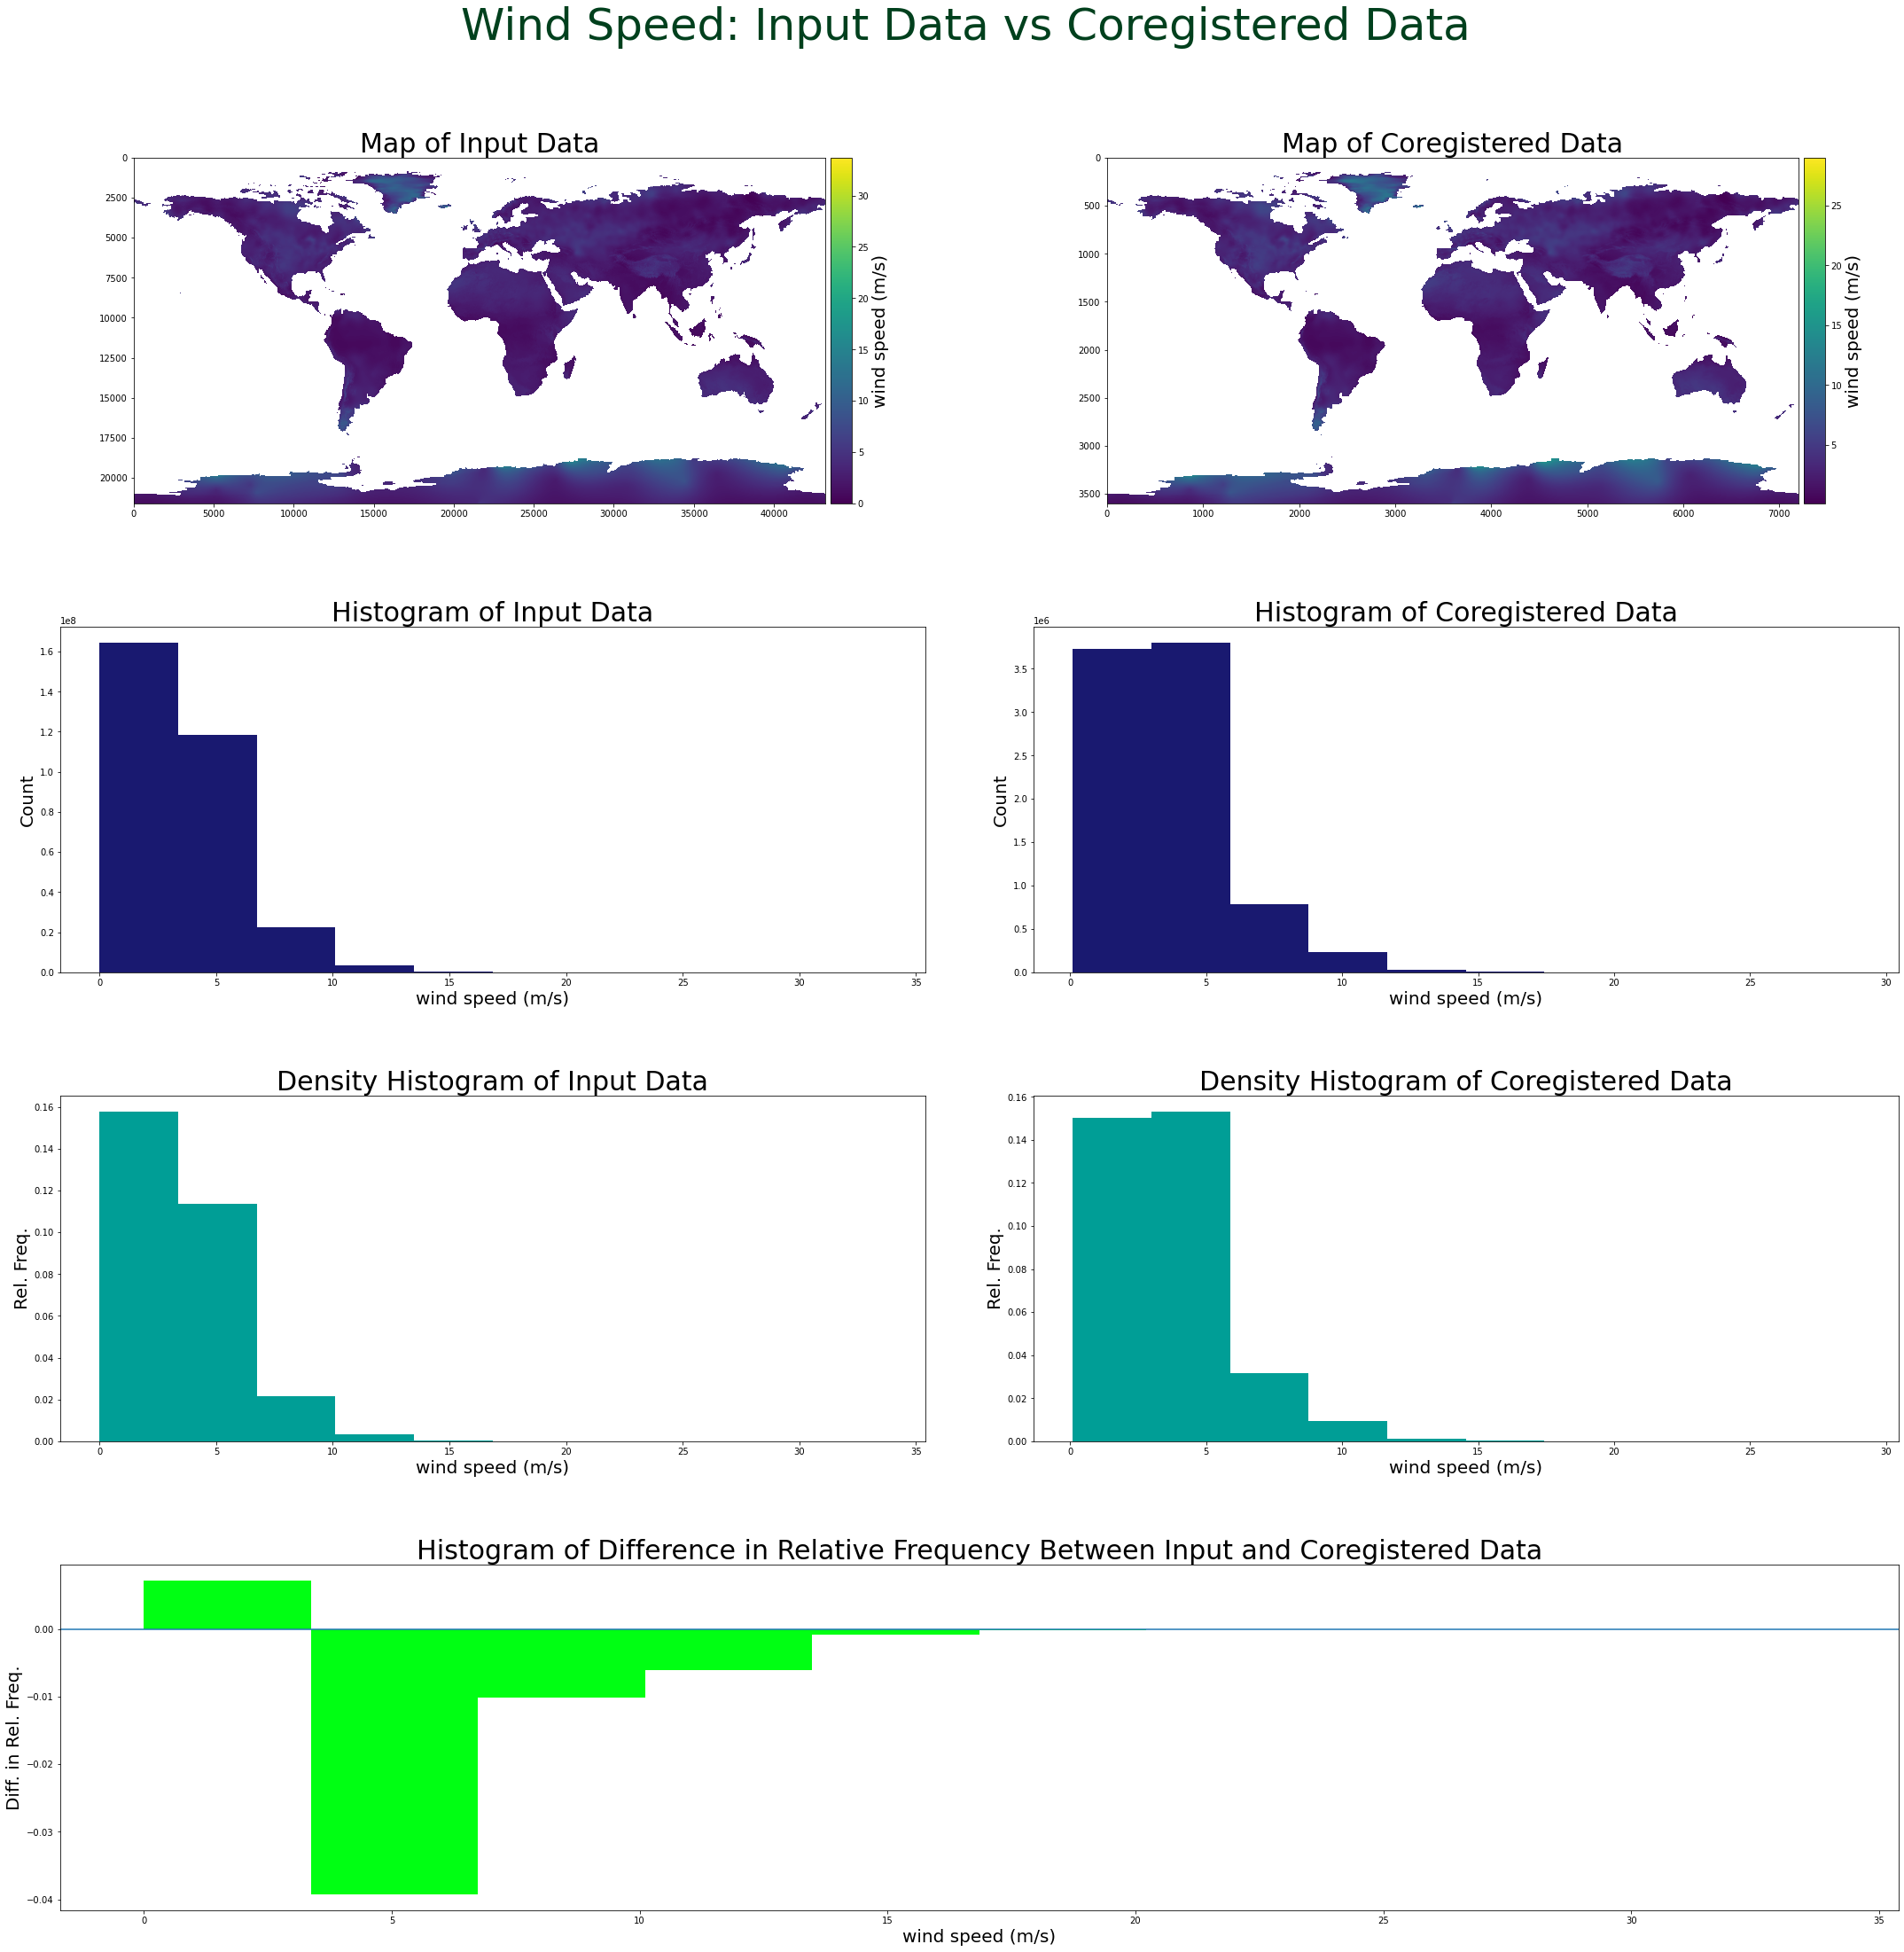

In [ ]:
visualize_difference(wind_in, wind_cln, "Wind Speed", "wind speed (m/s)")

### Visualize each feature on a map <a class="anchor" id="visual"></a>

We can look at each of the cleaned and repositioned raster datasets individually on a map of the continents using a heatmap.

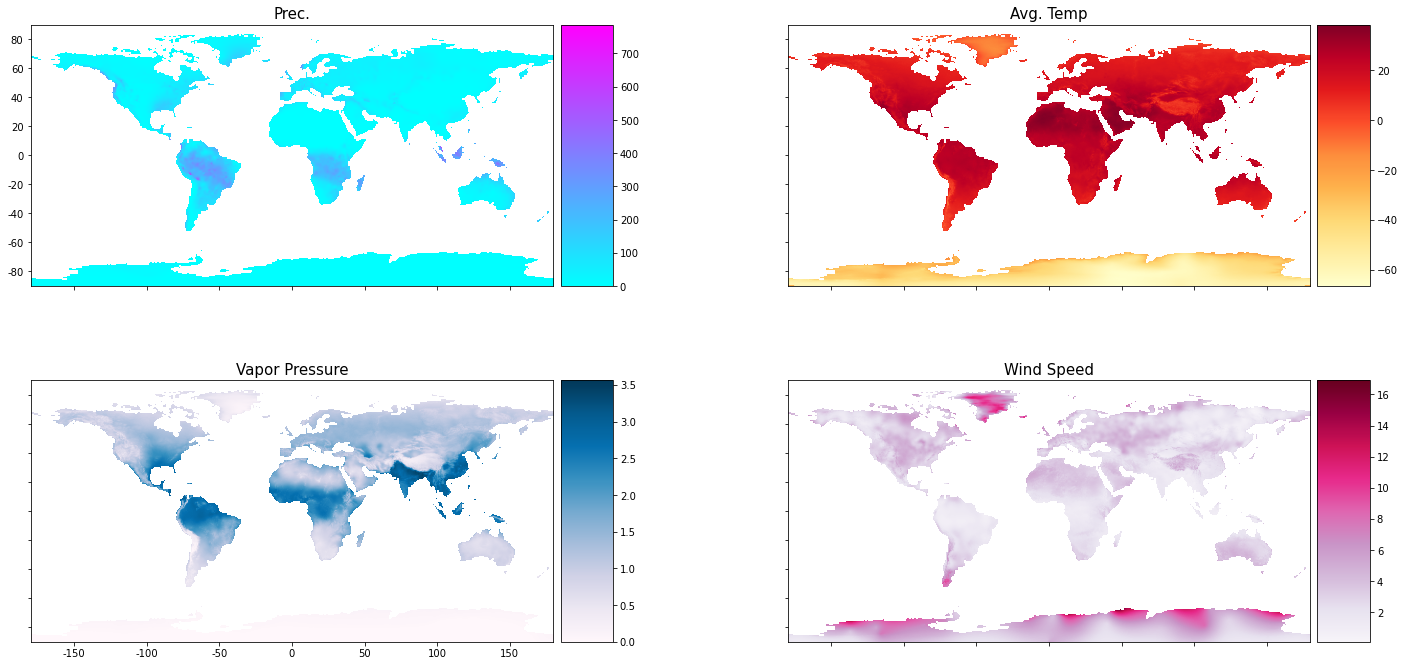

In [ ]:
features = Raster([prec_cln, temp_cln, vapr_cln, wind_cln])

features.prec_cleaned.cmap = "cool"
features.temp_cleaned.cmap = "YlOrRd"
features.vapr_cleaned.cmap = "PuBu"
features.wind_cleaned.cmap = "PuRd"


features.plot(
    title_fontsize=15,
    label_fontsize=10,
    legend_fontsize=10,
    names=["Prec.", "Avg. Temp", "Vapor Pressure", "Wind Speed"],
    fig_kwds={"figsize": (24, 12)},
    subplots_kwds={"wspace": 0.3}
);


### All together <a class="anchor" id="all"></a>
We create a figure with a single subplot, with x and y limits. Using the rasterio library, we can open each of the four raster files, prec_cln, temp_cln, vapr_cln, and wind_cln, which contain the different climate features. Then we plot the histograms for each of the four raster files on the same subplot, setting the alpha, color, and density parameters, as well as a label for each of the histograms. The result is a single plot containing four histograms, each corresponding to one of the four climate features.

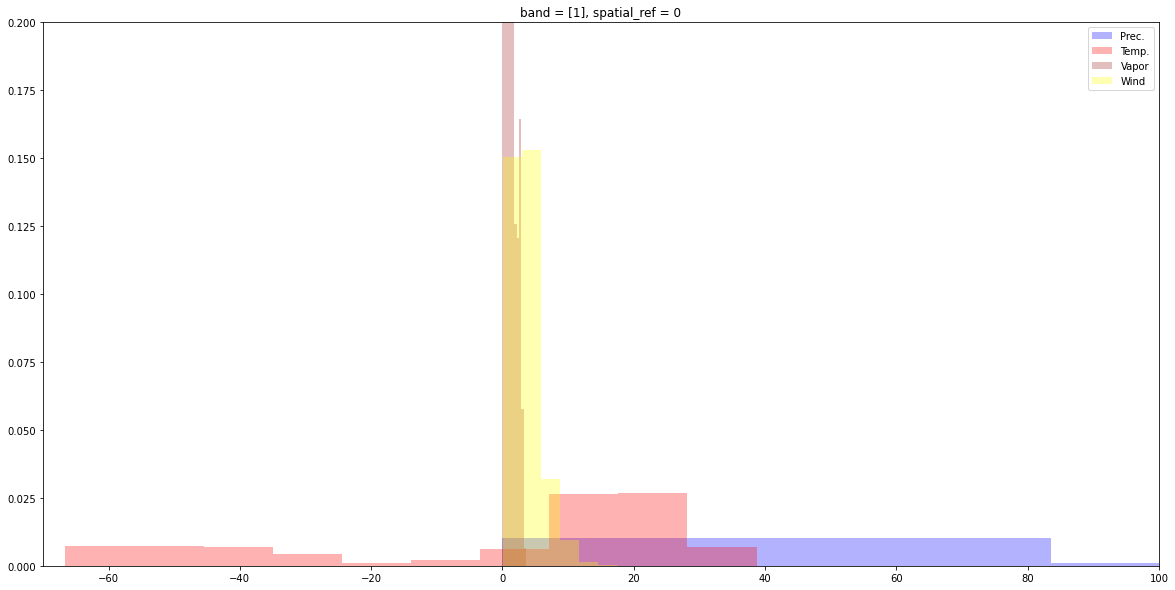

In [ ]:
from rasterio.plot import show_hist
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
ax.set_xlim([-70, 100])
ax.set_ylim([0, 0.2])
rxr.open_rasterio(prec_cln, masked = True).plot.hist(ax=ax, alpha = 0.3, color = "blue" ,density = True, label = "Prec.")
rxr.open_rasterio(temp_cln, masked = True).plot.hist(ax=ax, alpha = 0.3, color = "red",density = True, label = "Temp.")
rxr.open_rasterio(vapr_cln, masked = True).plot.hist(ax=ax, alpha = 0.3, color = "brown",density = True, label = "Vapor")
rxr.open_rasterio(wind_cln, masked = True).plot.hist(ax=ax, alpha = 0.3, color = "yellow",density = True, label = "Wind")
ax.legend()


## PART 3: Regression Analysis <a class="anchor" id="regression"></a>

In this last part, we evaluate the performance of a two regression models: Linear Regression and Random Forest Regression. We are going to be predicting soil organic carbon values using a spacial dataset we compiled and hosted on an AWS bucket. We will be predicting these values at cells in the tranformed raster data set using the features we extracted before (Wind speed, temperature, ...). Soil organic carbon values are useful when deciding where to plant crops making them extremely useful to predict.

### Colinearity

To determine the best model for predicting soil organic carbon, we initially considered using a linear regression. However, due to potential co-linearity in our data, we also decided to compare the performance of a random forest regression. Before training the linear regression model, we checked for independence among the features by calculating the variance inflation factor (VIF). This allowed us to identify any strong correlations between features and ensure that they were not influencing the model's accuracy or interpretability. Our initial hypothesis was that linear regression would be much worse due to the fact that climate data may be highly dependent.

### Training

To improve the prediction of soil organic carbon values, we conducted some investigation and preprocessing on our training data. We read in our raster file containing spatial data on soil organic carbon values, dropping any missing values. We then split the data into X (predictor variables) and y (target variable) train and test sets. Using these sets, we trained and evaluated both regression models to make predictions on the testing set. To determine the performance of each model, we calculated the Root Mean Squared Error (RMSE) and also analyzed additional metrics such as standard deviation. Finally, we conducted a t-test to compare the performance of the Random Forest model and the Linear regression model and determine which model is more effective at predicting soil organic carbon values.

Note We ran the model training and printed the RMSE values. This took a long time so we redefined the output arrays for convenience.

In [ ]:

df_rand = features.sample(size=100)
X = add_constant(df_rand)
X = X.drop(columns = "geometry")
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)


const           15.110663
prec_cleaned     1.602868
temp_cleaned     3.013561
vapr_cleaned     4.359706
wind_cleaned     1.469128
dtype: float64

In [ ]:
training = rio.open("s3://320final/soctraining.tif")
training_a = features.extract_raster(training)
training = training.dropna()
X = training_a.drop(columns=["value", "geometry"]).values 
y = training_a["value"].values

In [ ]:
import random
count = 0;
performance_lin = []
while count < 30:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    performance_lin.append(round(math.sqrt(mean_squared_error(y_test, predictions)),4))
    count+=1
print(performance_lin)

[0.6037, 0.6892, 0.278, 0.4554, 0.6122, 0.3516, 0.6582, 0.5238, 0.4955, 0.53, 0.5246, 0.5933, 0.6531, 0.3341, 0.4619, 0.2521, 0.3224, 0.3563, 0.553, 0.3002, 0.6032, 0.5531, 0.258, 0.3276, 0.4421, 0.4424, 0.614, 0.4188, 0.2651, 0.4152]


In [ ]:
pipeline = Pipeline(
    [('scaling', StandardScaler()),
     ('regressor', RandomForestRegressor())]
)
pipeline.fit(X, y);

In [ ]:
performance_forest = cross_validate(
    estimator= pipeline,
    X=X,
    y=y,
    scoring="neg_root_mean_squared_error",
    cv=30,
    n_jobs=1,
)
performance_forest = [-1*round(num,4) for num in performance_forest['test_score']]
print(performance_forest)

[0.3914, 0.4282, 0.3081, 0.0471, 0.1262, 0.0461, 0.0531, 0.0386, 0.0034, 0.0192, 0.0203, 0.0249, 0.0303, 0.04, 0.0279, 0.061, 0.0182, 5.3279, 0.0518, 0.0176, 0.0026, 0.0218, 0.0157, 0.0158, 0.0323, 0.0243, 0.0174, 0.0191, 4.1517, 0.1524]


### Evaluation <a class="anchor" id="evaluation"></a>

We print and redefine the RMSE values because training and evaluating the model can take a while. Below are general metrics for both models as well as a t-test.

In [ ]:
import numpy as np

performance_lin = [0.6037, 0.6892, 0.278, 0.4554, 0.6122, 0.3516, 0.6582, 0.5238, 0.4955, 0.53, 0.5246, 0.5933, 0.6531, 0.3341, 0.4619, 0.2521, 0.3224, 0.3563, 0.553, 0.3002, 0.6032, 0.5531, 0.258, 0.3276, 0.4421, 0.4424, 0.614, 0.4188, 0.2651, 0.4152]
performance_forest = [0.3914, 0.4282, 0.3081, 0.0471, 0.1262, 0.0461, 0.0531, 0.0386, 0.0034, 0.0192, 0.0203, 0.0249, 0.0303, 0.04, 0.0279, 0.061, 0.0182, 5.3279, 0.0518, 0.0176, 0.0026, 0.0218, 0.0157, 0.0158, 0.0323, 0.0243, 0.0174, 0.0191, 4.1517, 0.1524]

# Evaluating linear regression
# Calculate mean and standard deviation of RMSE
mean_lin = np.mean(performance_lin)
std_lin = np.std(performance_lin)
print("Linear Regression Model Performance")
print("Mean RMSE:", mean_lin)
print("Standard Deviation of RMSE:", std_lin, "\n")

# Evaluating random forest regression
# Calculate mean and standard deviation of RMSE
mean_forest = np.mean(performance_forest)
std_forest = np.std(performance_forest)
print("Random Forest Regression Model Performance")
print("Mean RMSE:", mean_forest)
print("Standard Deviation of RMSE:", std_forest)

Linear Regression Model Performance
Mean RMSE: 0.46293666666666666
Standard Deviation of RMSE: 0.1324413517582615 

Random Forest Regression Model Performance
Mean RMSE: 0.38448000000000004
Standard Deviation of RMSE: 1.1787380103031095


In [ ]:
# Perform t-test to compare performance of linear and random forest models
from scipy import stats

t_test = stats.ttest_rel(performance_lin, performance_forest)

print("T-Test Results")
print("T-Statistic:", round(t_test.statistic,4))
print("P-Value:", round(t_test.pvalue,4))

# Interpretation
if t_test.pvalue < 0.05:
    print("The difference in performance between the linear and random forest models is statistically significant")
else:
    print("The difference in performance between the linear and random forest models is not statistically significant")

T-Test Results
T-Statistic: 0.3458
P-Value: 0.732
The difference in performance between the linear and random forest models is not statistically significant


13.976910180394166
986.7
0.04


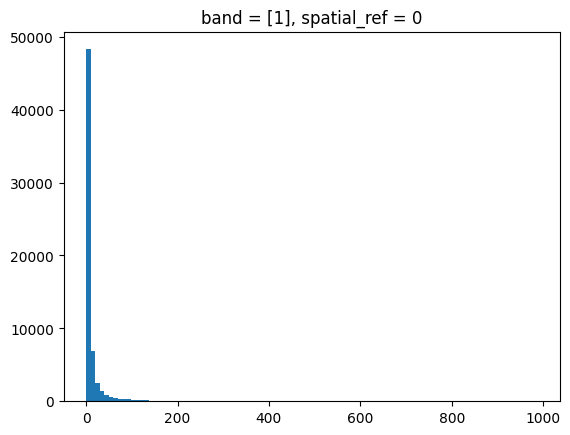

In [6]:
import rasterio as rio
import matplotlib.pyplot as plt
import rioxarray as rxr

# 
soc_data = rxr.open_rasterio("https://320final.s3.amazonaws.com/soctraining.tif", masked = True)
soc_data.plot.hist(bins=100)
mean_value = soc_data.mean().values
max_soc = soc_data.max().values
min_soc = soc_data.min().values
print(mean_value)
print(max_soc)
print(min_soc)

## Conclusion <a class="anchor" id="conclusion"></a>

The range of values for soil organic carbon in our datasets is 0.04 to 986.7 with a mean of 13.97. Both the linear regression and random forest models perform well in predicting soil organic carbon values based on these statistics, with the random forest model showing slightly better performance. The random forest model has consistently lower RMSE values and more consistent results compared to the linear regression model, which has more variable RMSE values and may be affected by outliers. However, the differences in performance between the two models are not statistically significant. It is worth noting that the chosen climate features in the dataset may not have strong dependencies on each other, which could explain the decent performance of the linear regression model. Overall, the random forest model appears to be the more effective choice for predicting soil organic carbon values.

Our conclusion in meme format:
https://twitter.com/seanjtaylor/status/1550326602105466880?s=46&t=2uJgFqXiXfI53aRKYPVAeQ